### Multi Factor Models

#### Fama - French 3 factor model (FF93)

$$E(R_i) - R_f = \beta_{iM} (E(R_M) - R_f) + \beta_{i \mathrm{SMB}} E(\mathrm{SMB}) + \beta_{i\mathrm{HML}} E(\mathrm{HML})
$$

Fama-French 3-Factor 모델은 자본 자산 가격 결정 모델(CAPM)을 확장해 주식 포트폴리오의 수익률을 설명하는 데 세 가지 위험 요소를 추가로 고려한다

1. 첫 번째 요소인 시장 위험 프리미엄(Mkt-RF)은 전체 시장의 초과 수익률을 나타낸다
2. 두 번째 요소인 규모 프리미엄(SMB; Small Minus Big)은 소형주가 대형주보다 높은 수익률을 낼 것이라는 가정에 기반한다
3. 마지막 요소인 가치 프리미엄(HML; High Minus Low)은 저평가된 주식(높은 장부가 대 시장가 비율)이 고평가된 주식보다 높은 수익률을 제공할 것이라고 가정한다

이 모델은 투자자들이 위험 요소들에 대한 노출 정도에 따라 요구하는 수익률이 달라진다는 개념을 도입해 주식의 수익률을 더 정확히 예측하고자 하는 모형이다.

한편, pandas datareader에서는 fama french 홈페이지에서 팩터 모델링을 위한 기본적인 데이터를 제공한다

In [1]:
import pandas_datareader.data as web
import statsmodels.api as sm
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

ff3_factors = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start = '1960-01-01')[0] * 0.01

In [2]:
ff3_factors.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1960-01,-0.0698,0.0209,0.0278,0.0033
1960-02,0.0117,0.0051,-0.0193,0.0029
1960-03,-0.0163,-0.0049,-0.0294,0.0035
1960-04,-0.0171,0.0032,-0.0228,0.0019
1960-05,0.0312,0.0121,-0.0370,0.0027


In [3]:
stock = yf.download('MSFT', start = '1960-01-01', end = '2024-02-01')

[*********************100%%**********************]  1 of 1 completed


In [4]:
stock_monthly_returns = stock['Adj Close'].resample('M').ffill().pct_change()

In [5]:
stock_monthly_returns.index = stock_monthly_returns.index.to_period('M')

In [6]:
data = pd.merge(
    ff3_factors, 
    stock_monthly_returns.rename('STOCK'), 
    left_index = True, 
    right_index = True, 
    how = 'inner'
).dropna()

In [7]:
data['STOCK_excess'] = data['STOCK'] - data['RF'] # excess return

In [8]:
data.head()

,Mkt-RF,SMB,HML,RF,STOCK,STOCK_excess
Date,,,,,,
1986-04,-0.0131,0.0278,-0.0287,0.0052,0.172727,0.167527
1986-05,0.0462,-0.0135,-0.0021,0.0049,0.085275,0.080375
1986-06,0.0103,-0.0096,0.0128,0.0052,-0.121429,-0.126629
1986-07,-0.0645,-0.0336,0.0470,0.0052,-0.073176,-0.078376
1986-08,0.0607,-0.0417,0.0351,0.0046,0.000000,-0.004600


statsmodels의 OLS를 사용해 모형을 추정한다

In [9]:
X = data[['Mkt-RF', 'SMB', 'HML']] # 각 risk factor지정
y = data['STOCK_excess'] # IBM의 초과 수익

X = sm.add_constant(X)

In [10]:
X_train, X_test, y_train, y_test = X[:'2021'], X['2022':], y[:'2021'], y['2022':]

In [11]:
ff93_model = sm.OLS(y_train, X_train).fit()

In [12]:
print(ff93_model.summary())

                            OLS Regression Results                            
Dep. Variable:           STOCK_excess   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     85.98
Date:                Sun, 24 Mar 2024   Prob (F-statistic):           1.72e-43
Time:                        23:46:01   Log-Likelihood:                 499.30
No. Observations:                 429   AIC:                            -990.6
Df Residuals:                     425   BIC:                            -974.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0149      0.004      3.998      0.0

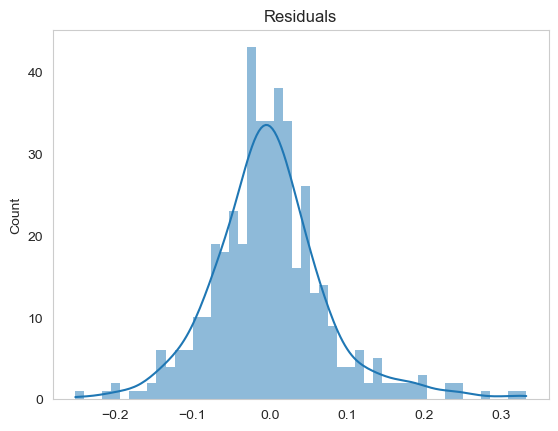

In [13]:
sns.histplot(ff93_model.resid, bins = 50, edgecolor = 'none', kde = True)
plt.grid(False)
plt.title('Residuals')
plt.show()

In [14]:
y_pred_ff93 = ff93_model.predict(X_test)
y_pred_ff93.head()

Date
2022-01   -0.142268
2022-02   -0.044284
2022-03    0.070574
2022-04   -0.141059
2022-05   -0.051552
Freq: M, dtype: float64

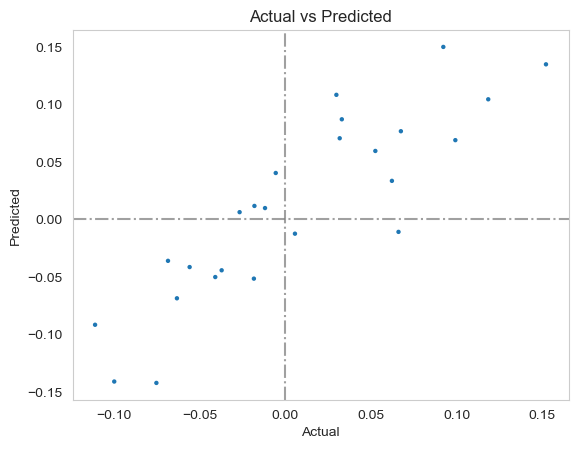

In [15]:
plt.scatter(y_test, y_pred_ff93, marker = 'o', s = 10, edgecolor = 'none')
plt.grid(False)
plt.axhline(0, color = 'gray', alpha = 0.75, linestyle = '-.')
plt.axvline(0, color = 'gray', alpha = 0.75, linestyle = '-.')
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

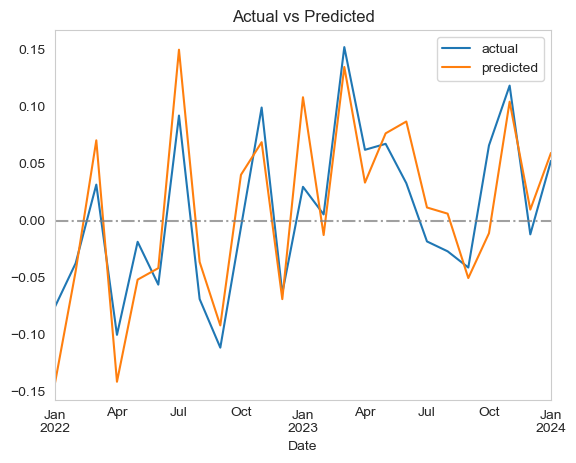

In [16]:
y_test.plot(label = 'actual')
y_pred_ff93.plot(label = 'predicted')
plt.grid(False)
plt.legend()
plt.axhline(0, color = 'gray', alpha = 0.75, ls = '-.')
plt.title('Actual vs Predicted')
plt.show()

#### Carhart Four-Factor Model (FF97)

$$E(R_i) - R_f = \beta_{iM} (E(R_M) - R_f) + \beta_{i \mathrm{SMB}} E(\mathrm{SMB}) + \beta_{i\mathrm{HML}} E(\mathrm{HML}) + \beta_{i \mathrm{MOM}} E(\mathrm{MOM})
$$

Carhart의 4-Factor 모델은 Fama-French 3-Factor 모델에 기반하여, 주식의 수익률을 시장 위험 프리미엄, 규모 프리미엄, 가치 프리미엄 뿐만 아니라 모멘텀 요인으로도 설명하려고 한다. 모멘텀 요인은 최근 12개월 동안 성과가 좋았던 주식이 그 다음 달에도 계속해서 성과가 좋을 것이라는 가정에 기초한다.

이 4요인 모델은 금융 시장의 다양한 위험 요소들과 수익률 패턴을, 특히 모멘텀 효과를 중시한 모형이다.

In [17]:
momentum = ff3_factors['Mkt-RF'].rolling(window = 12).mean()

In [18]:
data = pd.merge(
    ff3_factors, 
    momentum.rename('MOM'), 
    left_index = True, 
    right_index = True, 
    how = 'inner'
).dropna()

In [19]:
data = pd.merge(
    data,
    stock_monthly_returns.rename('STOCK'),
    left_index = True,
    right_index = True,
    how = 'inner'
).dropna()

In [20]:
data.head()

,Mkt-RF,SMB,HML,RF,MOM,STOCK
Date,,,,,,
1986-04,-0.0131,0.0278,-0.0287,0.0052,0.021492,0.172727
1986-05,0.0462,-0.0135,-0.0021,0.0049,0.021100,0.085275
1986-06,0.0103,-0.0096,0.0128,0.0052,0.020900,-0.121429
1986-07,-0.0645,-0.0336,0.0470,0.0052,0.016142,-0.073176
1986-08,0.0607,-0.0417,0.0351,0.0046,0.022050,0.000000


In [21]:
data['STOCK_excess'] = data['STOCK'] - data['RF'] # excess return

In [22]:
X = data[['Mkt-RF', 'SMB', 'HML', 'MOM']] # 각 risk factor지정
y = data['STOCK_excess'] # IBM의 초과 수익

X = sm.add_constant(X)

In [23]:
X_train, X_test, y_train, y_test = X[:'2021'], X['2022':], y[:'2021'], y['2022':]

In [24]:
ff97_model = sm.OLS(y, X).fit()

In [25]:
print(ff97_model.summary())

                            OLS Regression Results                            
Dep. Variable:           STOCK_excess   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     71.27
Date:                Sun, 24 Mar 2024   Prob (F-statistic):           1.04e-46
Time:                        23:46:01   Log-Likelihood:                 538.19
No. Observations:                 454   AIC:                            -1066.
Df Residuals:                     449   BIC:                            -1046.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0138      0.004      3.467      0.0

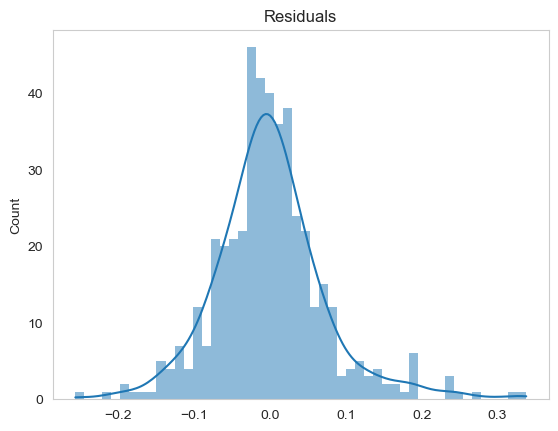

In [26]:
sns.histplot(ff97_model.resid, bins = 50, edgecolor = 'none', kde = True)
plt.grid(False)
plt.title('Residuals')
plt.show()

In [27]:
y_pred_ff97 = ff97_model.predict(X_test)
y_pred_ff97.head()

Date
2022-01   -0.134978
2022-02   -0.043192
2022-03    0.069835
2022-04   -0.137842
2022-05   -0.050714
Freq: M, dtype: float64

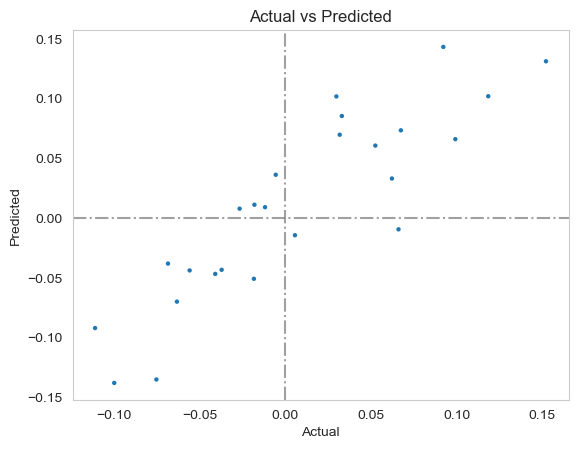

In [28]:
plt.scatter(y_test, y_pred_ff97, marker = 'o', s = 10, edgecolor = 'none')
plt.grid(False)
plt.axhline(0, color = 'gray', alpha = 0.75, linestyle = '-.')
plt.axvline(0, color = 'gray', alpha = 0.75, linestyle = '-.')
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

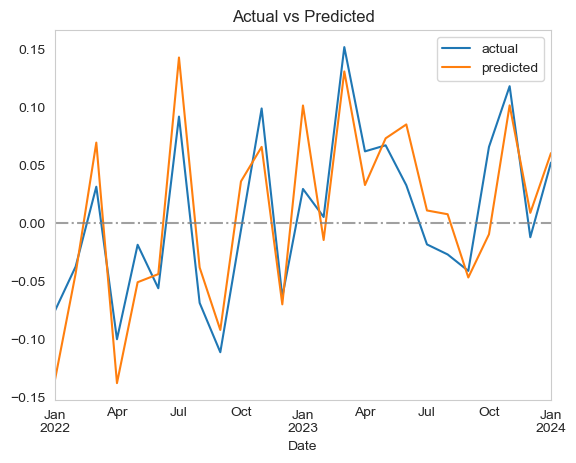

In [29]:
y_test.plot(label = 'actual')
y_pred_ff97.plot(label = 'predicted')
plt.grid(False)
plt.legend()
plt.axhline(0, color = 'gray', alpha = 0.75, ls = '-.')
plt.title('Actual vs Predicted')
plt.show()

#### Fama - French 5 factor model (FF15)

Fama-French 5-Factor 모델은 기존의 3-Factor 모델을 확장하여, 주식 포트폴리오 수익률을 설명하는데 두 가지 추가적인 위험 요소를 포함한다. 이 모델은 시장 위험 프리미엄, 규모 프리미엄(SMB; Small Minus Big), 가치 프리미엄(HML; High Minus Low)에 더해, 수익성 프리미엄(RMW; Robust Minus Weak)과 투자 스타일 프리미엄(CMA; Conservative Minus Aggressive)을 추가한다. 

$$E(R_i) - R_f = \beta_{iM} (E(R_M) - R_f) + \beta_{i\mathrm{SMB}} E(\mathrm{SMB}) + \beta_{i\mathrm{HML}} E(\mathrm{HML}) + \beta_{i\mathrm{RMW}} E(\mathrm{RMW}) + \beta_{i\mathrm{CMA}} E(\mathrm{CMA})$$


수익성 프리미엄은 높은 영업 이익률을 가진 회사들이 낮은 이익률을 가진 회사들보다 높은 기대 수익률을 제공한다는 가정에 기반한다. 투자 스타일 프리미엄은 보수적인 투자 전략을 취하는 회사들이 공격적으로 자산을 확장하는 회사들보다 더 높은 기대 수익률을 제공한다는 것을 나타낸다. 

이 추가적인 요소들은 투자자들이 주식 시장에서 수익률을 예측하고 포트폴리오를 구성할 때 고려해야 할 중요한 요소라고 주장한다.

In [30]:
ff5_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start = '1960-01-01')[0] * 0.01

In [31]:
ff5_factors.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1963-07,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0027
1963-08,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0025
1963-09,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0027
1963-10,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0029
1963-11,-0.0085,-0.0088,0.0175,-0.0051,0.0224,0.0027


In [32]:
data = pd.merge(
    ff5_factors, 
    stock_monthly_returns.rename('STOCK'), 
    left_index = True, 
    right_index = True, 
    how = 'inner'
).dropna()

In [33]:
data['STOCK_excess'] = data['STOCK'] - data['RF'] # excess return

In [34]:
X = data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']] # 각 risk factor지정
y = data['STOCK_excess'] # IBM의 초과 수익

X = sm.add_constant(X)

In [35]:
X_train, X_test, y_train, y_test = X[:'2021'], X['2022':], y[:'2021'], y['2022':]

In [36]:
ff15_model = sm.OLS(y_train, X_train).fit()

In [37]:
print(ff15_model.summary())

                            OLS Regression Results                            
Dep. Variable:           STOCK_excess   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     56.30
Date:                Sun, 24 Mar 2024   Prob (F-statistic):           8.31e-45
Time:                        23:46:03   Log-Likelihood:                 506.98
No. Observations:                 429   AIC:                            -1002.
Df Residuals:                     423   BIC:                            -977.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0163      0.004      4.270      0.0

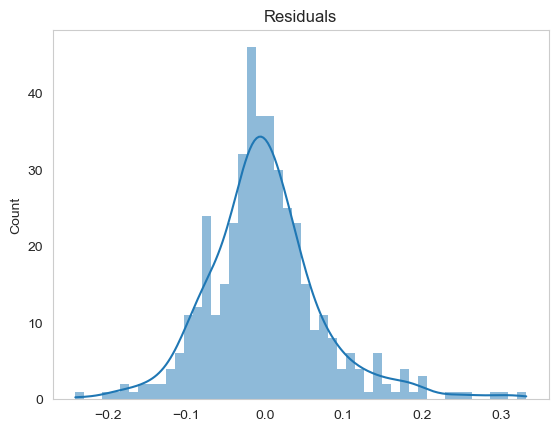

In [38]:
sns.histplot(ff15_model.resid, bins = 50, edgecolor = 'none', kde = True)
plt.grid(False)
plt.title('Residuals')
plt.show()

In [39]:
y_pred_ff15 = ff15_model.predict(X_test)
y_pred_ff15.head()

Date
2022-01   -0.167612
2022-02   -0.062345
2022-03    0.031914
2022-04   -0.157845
2022-05   -0.058126
Freq: M, dtype: float64

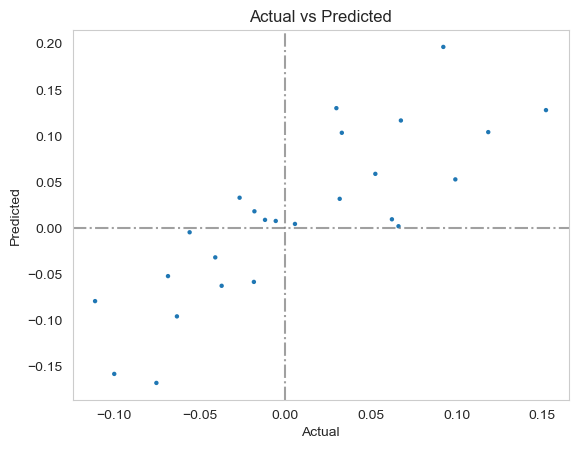

In [40]:
plt.scatter(y_test, y_pred_ff15, marker = 'o', s = 10, edgecolor = 'none')
plt.grid(False)
plt.axhline(0, color = 'gray', alpha = 0.75, linestyle = '-.')
plt.axvline(0, color = 'gray', alpha = 0.75, linestyle = '-.')
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

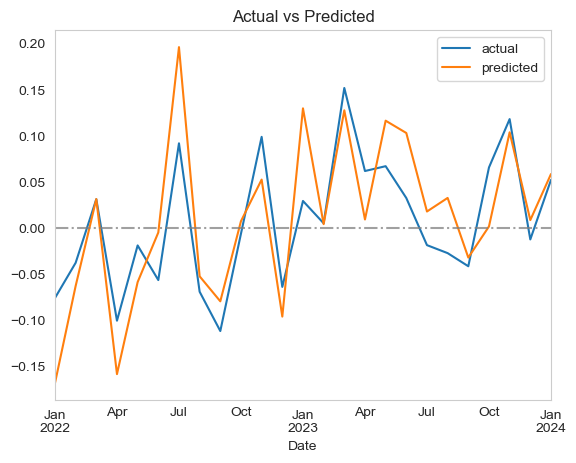

In [41]:
y_test.plot(label = 'actual')
y_pred_ff15.plot(label = 'predicted')
plt.grid(False)
plt.legend()
plt.axhline(0, color = 'gray', alpha = 0.75, ls = '-.')
plt.title('Actual vs Predicted')
plt.show()

#### Comparison Results

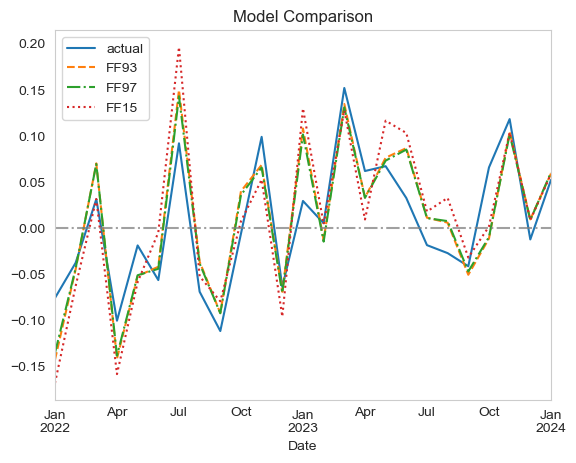

In [43]:
y_test.plot(label = 'actual')
y_pred_ff93.plot(label = 'FF93', ls = '--')
y_pred_ff97.plot(label = 'FF97', ls = '-.')
y_pred_ff15.plot(label = 'FF15', ls = ':')
plt.grid(False)
plt.legend()
plt.axhline(0, color = 'gray', alpha = 0.75, ls = '-.')
plt.title('Model Comparison')
plt.show()

#### Additional Factors

이외에도 여러개의 factor가 사용될 수 있다

- MOM (Momentum) : 최근 수익률이 높은 주식이 계속해서 높은 수익률을 제공하는 경향이 있다는 것을 나타낸다. 모멘텀은 단기에서 중기에 걸친 주가의 추세를 반영한다.
- QAL (Quality) : 고품질의 기업이 낮은 품질의 기업보다 더 나은 수익률을 제공한다는 개념에 기초한다. 품질은 재무 건전성, 안정적인 수익성, 효율적인 운영 등 다양한 지표로 측정될 수 있다.
- VOL (Volatility) : 변동성 요인은 자산의 가격 변동성이 미래의 수익률에 미치는 영향을 설명한다. 일반적으로 높은 변동성을 가진 자산은 더 높은 위험을 가지며, 이에 따라 높은 기대 수익률을 요구한다.
- LIQ (Liquidity) : 유동성 요인은 시장에서 자산을 얼마나 쉽게 매매할 수 있는지에 대한 척도인 유동성이 수익률에 미치는 영향을 나타낸다. 일반적으로 유동성이 낮은 자산(즉, 매매하기 어려운 자산)은 유동성 프리미엄을 요구하며, 이는 더 높은 예상 수익률로 이어질 수 있다. 유동성이 높은 시장에서는 자산을 매매하는데 드는 비용이 낮기 때문에, 유동성이 높은 자산은 낮은 수익률을 제공할 수 있다.

이외 기타 거시경제 요인은 인플레이션, 경제 성장률, 금리, 환율 등과 같은 거시경제적 상태가 금융 시장과 자산 가격에 미치는 영향을 설명한다. 